# Deep Q-learning or Q-network (DQN)

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import numpy as np

In [2]:
import tensorflow as tf
print('TensorFlow Version: {}'.format(tf.__version__))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.12.0
Default GPU Device: /device:GPU:0


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

>**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [3]:
import gym

## Create the Cart-Pole game environment
# env = gym.make('CartPole-v0') # 200 total reward as goal
env = gym.make('CartPole-v1') # 500 total reward as goal

We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [4]:
# env.reset()
# batch = []
# for _ in range(1000):
#     # env.render()
#     action = env.action_space.sample()
#     state, reward, done, info = env.step(action) # take a random action
#     batch.append([action, state, reward, done, info])
#     #print('state, action, reward, done, info:', state, action, reward, done, info)
#     if done:
#         env.reset()

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [5]:
# batch[0], batch[0][1].shape

In [6]:
# actions = np.array([each[0] for each in batch])
# states = np.array([each[1] for each in batch])
# rewards = np.array([each[2] for each in batch])
# dones = np.array([each[3] for each in batch])
# infos = np.array([each[4] for each in batch])

In [7]:
# print(rewards[-20:])
# print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
# print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
# print(np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
# print(np.max(np.array(rewards)), np.min(np.array(rewards)))
# print(np.max(np.array(states)), np.min(np.array(states)))

The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [8]:
def model_input(state_size):
    actions = tf.placeholder(tf.int32, [None], name='actions')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    is_training = tf.placeholder(tf.bool, name='is_training')
    return actions, states, targetQs, is_training

In [9]:
def init_xavier(random_seed=1, dtype=tf.float32, uniform=False):
    xavier = tf.contrib.layers.xavier_initializer(
        dtype=dtype,
        seed=tf.set_random_seed(random_seed), 
        uniform=uniform) # False: normal
    return xavier

In [10]:
def mlp(inputs, units, trainable=True):
    outputs = tf.layers.dense(
        inputs=inputs,
        units=units,
        activation=None,
        use_bias=True,
        kernel_initializer=init_xavier(), # Xavier with normal init
        bias_initializer=tf.zeros_initializer(),
        kernel_regularizer=None,
        bias_regularizer=None,
        activity_regularizer=None,
        kernel_constraint=None,
        bias_constraint=None,
        trainable=trainable,
        name=None,
        reuse=None)
    return outputs

In [11]:
# tf.nn.leaky_relu(
#     features,
#     alpha=0.2,
#     name=None
# )
def nl(inputs, alpha=0.2):
    outputs = tf.maximum(alpha * inputs, inputs)
    return outputs

In [12]:
def bn(inputs, training=True):
    outputs = tf.layers.batch_normalization(
        inputs=inputs,
        axis=-1,
        momentum=0.99,
        epsilon=0.001,
        center=True,
        scale=True,
        beta_initializer=tf.zeros_initializer(),
        gamma_initializer=tf.ones_initializer(),
        moving_mean_initializer=tf.zeros_initializer(),
        moving_variance_initializer=tf.ones_initializer(),
        beta_regularizer=None,
        gamma_regularizer=None,
        beta_constraint=None,
        gamma_constraint=None,
        training=training,
        trainable=True,
        name=None,
        reuse=None,
        renorm=False,
        renorm_clipping=None,
        renorm_momentum=0.99,
        fused=None,
        virtual_batch_size=None,
        adjustment=None)
    return outputs

In [13]:
# Actor-Critic/ D/Q
def D(states, action_size, hidden_size, reuse=False, alpha=0.2, is_training=False):
    with tf.variable_scope('D', reuse=reuse):
        # First fully connected layer
        h = mlp(inputs=states, units=hidden_size)
        h = bn(inputs=h, training=is_training)
        h = nl(h)
        print(states.shape, h.shape)
        
        # Second fully connected layer
        h = mlp(inputs=h, units=hidden_size)
        h = bn(inputs=h, training=is_training)
        h = nl(h)
        print(h.shape)
        
        # Output layer
        actions = mlp(inputs=h, units=action_size)
        return actions

In [14]:
# Actor-Critic/ D/Q
def D_target(states, action_size, hidden_size, reuse=False, alpha=0.2, is_training=False):
    with tf.variable_scope('D_target', reuse=reuse):
        # First fully connected layer
        h = mlp(inputs=states, units=hidden_size)
        h = bn(inputs=h, training=is_training)
        h = nl(h)
        print(states.shape, h.shape)
        
        # Second fully connected layer
        h = mlp(inputs=h, units=hidden_size)
        h = bn(inputs=h, training=is_training)
        h = nl(h)
        print(h.shape)
        
        # Output layer
        actions = mlp(inputs=h, units=action_size)
        return actions

In [15]:
def model_loss(actions, states, targetQs, action_size, hidden_size, is_training):
    
    actions_logits = D(states=states, hidden_size=hidden_size, action_size=action_size, 
                       is_training=is_training)
    actions_target = D_target(states=states, hidden_size=hidden_size, action_size=action_size, 
                              is_training=is_training)
    
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    
    Qs = tf.reduce_max(actions_logits*actions_labels, axis=1)
    
    loss = tf.reduce_mean((Qs - targetQs)**2)
    
    return actions_logits, loss, actions_target

In [16]:
def model_opt(loss, learning_rate, gamma):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('D')]
    d_vars_tgt = [var for var in t_vars if var.name.startswith('D_target')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        opt = tf.train.AdamOptimizer(learning_rate).minimize(loss, var_list=d_vars)
        
        opt_tgt = [d_vars_tgt[i].assign((d_vars_tgt[i]*gamma) + (d_vars[i]*(1 - gamma))) 
                   for i in range(len(d_vars_tgt))]

    return opt, opt_tgt

In [17]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate, gamma):

        # Data of the Model: make the data available inside the framework
        self.actions, self.states, self.targetQs, self.is_training = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.loss, self.actions_target = model_loss(
            action_size=action_size, hidden_size=hidden_size,
            states=self.states, actions=self.actions, targetQs=self.targetQs, 
            is_training=self.is_training)

        # Update the model: backward pass and backprop
        self.opt, self.opt_target = model_opt(loss=self.loss, learning_rate=learning_rate, gamma=gamma)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [18]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [19]:
# print('state size:{}'.format(states.shape), 
#       'actions:{}'.format(actions.shape)) 
# print('action size:', np.max(actions) - np.min(actions)+1)

In [22]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
action_size = 2
state_size = 4
hidden_size = 64               # number of units in each Q-network hidden layer
learning_rate = 0.0001         # Q-network learning rate

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 128               # experience mini-batch size
gamma = 0.99                   # future reward discount

In [23]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, 
              learning_rate=learning_rate, gamma=gamma)

# Init the memory
memory = Memory(max_size=memory_size)

(?, 4) (?, 64)
(?, 64)
(?, 4) (?, 64)
(?, 64)


## Populate the memory (exprience memory)

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [24]:
state = env.reset()

for _ in range(memory_size):
    
    action = env.action_space.sample()
    
    next_state, reward, done, _ = env.step(action)
    
    memory.buffer.append([state, action, next_state, reward, float(done)])
    
    state = next_state
    
    if done is True:
        state = env.reset()

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [25]:
def learn(sess, memory, batch_size):
    batch = memory.sample(batch_size)
    states = np.array([each[0] for each in batch])
    actions = np.array([each[1] for each in batch])
    next_states = np.array([each[2] for each in batch])
    rewards = np.array([each[3] for each in batch])
    dones = np.array([each[4] for each in batch])
    
    next_actions_target = sess.run(model.actions_target, feed_dict = {model.states: next_states, 
                                                                      model.is_training: False})
    
    nextQs = np.max(next_actions_target, axis=1) * (1-dones)
    
    targetQs = rewards + (gamma * nextQs)
    
    loss, _ = sess.run([model.loss, model.opt], feed_dict = {model.states: states, 
                                                             model.actions: actions,
                                                             model.targetQs: targetQs, 
                                                             model.is_training: True})
    return loss

In [26]:
def act(sess, state):
    
    action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1]), 
                                                              model.is_training: False})
    
    action = np.argmax(action_logits, axis=1)[0]
    #print(action)
    
    return action

In [ ]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list, loss_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
    
    # Training episodes/epochs
    for ep in range(11111):
        total_reward = 0
        loss_batch = []
        state = env.reset()

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action = act(sess, state)
            next_state, reward, done, _ = env.step(action)
            
            memory.buffer.append([state, action, next_state, reward, float(done)])
            
            total_reward += reward
            state = next_state

            # Training
            loss = learn(sess, memory, batch_size)
            loss_batch.append(loss)
            
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{}'.format(total_reward),
              'loss:{:.4f}'.format(np.mean(loss_batch)),
              'exploreP:{:.4f}'.format(explore_p))
        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        loss_list.append([ep, np.mean(loss_batch)])
        # Break episode/epoch loop
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:14.0000 R:14.0 loss:0.8083 exploreP:0.9986
Episode:1 meanR:17.0000 R:20.0 loss:0.8188 exploreP:0.9966
Episode:2 meanR:23.0000 R:35.0 loss:0.8222 exploreP:0.9932
Episode:3 meanR:31.0000 R:55.0 loss:0.8066 exploreP:0.9878
Episode:4 meanR:28.6000 R:19.0 loss:0.7916 exploreP:0.9859
Episode:5 meanR:26.5000 R:16.0 loss:0.8350 exploreP:0.9844
Episode:6 meanR:25.7143 R:21.0 loss:0.8666 exploreP:0.9823
Episode:7 meanR:24.5000 R:16.0 loss:0.8801 exploreP:0.9808
Episode:8 meanR:24.7778 R:27.0 loss:0.9115 exploreP:0.9782
Episode:9 meanR:23.6000 R:13.0 loss:0.9706 exploreP:0.9769
Episode:10 meanR:22.5455 R:12.0 loss:0.9123 exploreP:0.9757
Episode:11 meanR:23.3333 R:32.0 loss:0.9816 exploreP:0.9727
Episode:12 meanR:23.0769 R:20.0 loss:1.0080 exploreP:0.9707
Episode:13 meanR:22.5714 R:16.0 loss:0.9181 exploreP:0.9692
Episode:14 meanR:21.8000 R:11.0 loss:0.9314 exploreP:0.9682
Episode:15 meanR:22.5000 R:33.0 loss:0.8169 exploreP:0.9650
Episode:16 meanR:21.8235 R:11.0 loss:0.7035 explor

Episode:137 meanR:31.4100 R:81.0 loss:0.0314 exploreP:0.6743
Episode:138 meanR:31.4400 R:15.0 loss:0.0332 exploreP:0.6734
Episode:139 meanR:31.4200 R:26.0 loss:0.0342 exploreP:0.6716
Episode:140 meanR:31.6000 R:62.0 loss:0.0367 exploreP:0.6675
Episode:141 meanR:31.6400 R:19.0 loss:0.0338 exploreP:0.6663
Episode:142 meanR:31.8000 R:29.0 loss:0.0380 exploreP:0.6644
Episode:143 meanR:31.7200 R:16.0 loss:0.0311 exploreP:0.6633
Episode:144 meanR:31.4000 R:13.0 loss:0.0294 exploreP:0.6625
Episode:145 meanR:31.3300 R:12.0 loss:0.0354 exploreP:0.6617
Episode:146 meanR:31.2900 R:19.0 loss:0.0308 exploreP:0.6605
Episode:147 meanR:31.6500 R:68.0 loss:0.0329 exploreP:0.6561
Episode:148 meanR:31.6900 R:51.0 loss:0.0336 exploreP:0.6528
Episode:149 meanR:31.4500 R:23.0 loss:0.0322 exploreP:0.6513
Episode:150 meanR:30.8400 R:9.0 loss:0.0358 exploreP:0.6507
Episode:151 meanR:31.0800 R:43.0 loss:0.0329 exploreP:0.6480
Episode:152 meanR:31.4100 R:45.0 loss:0.0314 exploreP:0.6451
Episode:153 meanR:31.4300

Episode:272 meanR:25.5800 R:37.0 loss:0.0388 exploreP:0.4779
Episode:273 meanR:25.5600 R:20.0 loss:0.0399 exploreP:0.4770
Episode:274 meanR:25.5500 R:10.0 loss:0.0357 exploreP:0.4765
Episode:275 meanR:25.5700 R:14.0 loss:0.0359 exploreP:0.4759
Episode:276 meanR:25.4300 R:11.0 loss:0.0370 exploreP:0.4754
Episode:277 meanR:25.3900 R:31.0 loss:0.0395 exploreP:0.4739
Episode:278 meanR:25.4200 R:18.0 loss:0.0351 exploreP:0.4731
Episode:279 meanR:25.3700 R:12.0 loss:0.0384 exploreP:0.4725
Episode:280 meanR:25.5300 R:28.0 loss:0.0375 exploreP:0.4712
Episode:281 meanR:25.4700 R:11.0 loss:0.0335 exploreP:0.4707
Episode:282 meanR:25.1900 R:12.0 loss:0.0317 exploreP:0.4702
Episode:283 meanR:25.1800 R:34.0 loss:0.0371 exploreP:0.4686
Episode:284 meanR:25.1700 R:14.0 loss:0.0329 exploreP:0.4680
Episode:285 meanR:25.1600 R:10.0 loss:0.0338 exploreP:0.4675
Episode:286 meanR:25.1400 R:15.0 loss:0.0371 exploreP:0.4668
Episode:287 meanR:25.1400 R:14.0 loss:0.0425 exploreP:0.4662
Episode:288 meanR:25.240

Episode:408 meanR:16.6700 R:16.0 loss:0.0363 exploreP:0.3812
Episode:409 meanR:16.5900 R:10.0 loss:0.0359 exploreP:0.3808
Episode:410 meanR:16.5400 R:12.0 loss:0.0328 exploreP:0.3804
Episode:411 meanR:16.4900 R:15.0 loss:0.0350 exploreP:0.3798
Episode:412 meanR:16.5400 R:16.0 loss:0.0359 exploreP:0.3792
Episode:413 meanR:16.6700 R:26.0 loss:0.0351 exploreP:0.3783
Episode:414 meanR:16.6600 R:11.0 loss:0.0344 exploreP:0.3779
Episode:415 meanR:16.6100 R:12.0 loss:0.0343 exploreP:0.3774
Episode:416 meanR:16.5800 R:11.0 loss:0.0362 exploreP:0.3770
Episode:417 meanR:16.3800 R:10.0 loss:0.0380 exploreP:0.3766
Episode:418 meanR:16.4000 R:12.0 loss:0.0351 exploreP:0.3762
Episode:419 meanR:16.4200 R:12.0 loss:0.0409 exploreP:0.3758
Episode:420 meanR:16.4100 R:9.0 loss:0.0329 exploreP:0.3754
Episode:421 meanR:16.3400 R:9.0 loss:0.0362 exploreP:0.3751
Episode:422 meanR:16.4600 R:28.0 loss:0.0340 exploreP:0.3741
Episode:423 meanR:16.4900 R:14.0 loss:0.0316 exploreP:0.3736
Episode:424 meanR:16.6500 

Episode:543 meanR:14.6800 R:17.0 loss:0.0378 exploreP:0.3109
Episode:544 meanR:14.4200 R:10.0 loss:0.0327 exploreP:0.3106
Episode:545 meanR:14.4000 R:9.0 loss:0.0371 exploreP:0.3104
Episode:546 meanR:14.3800 R:13.0 loss:0.0337 exploreP:0.3100
Episode:547 meanR:14.4600 R:18.0 loss:0.0324 exploreP:0.3094
Episode:548 meanR:14.5300 R:22.0 loss:0.0344 exploreP:0.3088
Episode:549 meanR:14.5400 R:27.0 loss:0.0328 exploreP:0.3080
Episode:550 meanR:14.4800 R:19.0 loss:0.0319 exploreP:0.3074
Episode:551 meanR:14.5400 R:15.0 loss:0.0333 exploreP:0.3070
Episode:552 meanR:14.3200 R:9.0 loss:0.0329 exploreP:0.3067
Episode:553 meanR:14.4900 R:29.0 loss:0.0324 exploreP:0.3058
Episode:554 meanR:14.4200 R:9.0 loss:0.0302 exploreP:0.3056
Episode:555 meanR:14.4900 R:17.0 loss:0.0326 exploreP:0.3051
Episode:556 meanR:14.5600 R:22.0 loss:0.0323 exploreP:0.3044
Episode:557 meanR:14.5600 R:11.0 loss:0.0281 exploreP:0.3041
Episode:558 meanR:14.5800 R:10.0 loss:0.0371 exploreP:0.3038
Episode:559 meanR:14.6000 R

Episode:679 meanR:15.9100 R:12.0 loss:0.0250 exploreP:0.2526
Episode:680 meanR:15.8600 R:17.0 loss:0.0291 exploreP:0.2522
Episode:681 meanR:15.8100 R:10.0 loss:0.0287 exploreP:0.2520
Episode:682 meanR:15.7900 R:16.0 loss:0.0261 exploreP:0.2516
Episode:683 meanR:15.7700 R:14.0 loss:0.0355 exploreP:0.2512
Episode:684 meanR:15.7300 R:16.0 loss:0.0315 exploreP:0.2509
Episode:685 meanR:15.8100 R:18.0 loss:0.0277 exploreP:0.2504
Episode:686 meanR:15.7900 R:15.0 loss:0.0295 exploreP:0.2501
Episode:687 meanR:15.7300 R:18.0 loss:0.0313 exploreP:0.2496
Episode:688 meanR:15.7300 R:18.0 loss:0.0332 exploreP:0.2492
Episode:689 meanR:15.7900 R:15.0 loss:0.0314 exploreP:0.2488
Episode:690 meanR:15.7800 R:15.0 loss:0.0319 exploreP:0.2485
Episode:691 meanR:15.6800 R:10.0 loss:0.0258 exploreP:0.2482
Episode:692 meanR:15.5700 R:10.0 loss:0.0278 exploreP:0.2480
Episode:693 meanR:15.5800 R:18.0 loss:0.0336 exploreP:0.2476
Episode:694 meanR:15.6300 R:17.0 loss:0.0338 exploreP:0.2472
Episode:695 meanR:15.640

Episode:815 meanR:15.5600 R:19.0 loss:0.0314 exploreP:0.2061
Episode:816 meanR:15.5900 R:19.0 loss:0.0266 exploreP:0.2057
Episode:817 meanR:15.6100 R:16.0 loss:0.0317 exploreP:0.2054
Episode:818 meanR:15.6000 R:10.0 loss:0.0293 exploreP:0.2052
Episode:819 meanR:15.5300 R:10.0 loss:0.0237 exploreP:0.2050
Episode:820 meanR:15.4700 R:12.0 loss:0.0277 exploreP:0.2048
Episode:821 meanR:15.4500 R:16.0 loss:0.0296 exploreP:0.2045
Episode:822 meanR:15.3900 R:12.0 loss:0.0264 exploreP:0.2042
Episode:823 meanR:15.4000 R:19.0 loss:0.0312 exploreP:0.2039
Episode:824 meanR:15.3900 R:17.0 loss:0.0329 exploreP:0.2035
Episode:825 meanR:15.3400 R:18.0 loss:0.0254 exploreP:0.2032
Episode:826 meanR:15.2900 R:12.0 loss:0.0256 exploreP:0.2030
Episode:827 meanR:15.2400 R:16.0 loss:0.0269 exploreP:0.2027
Episode:828 meanR:15.2000 R:13.0 loss:0.0295 exploreP:0.2024
Episode:829 meanR:15.1200 R:11.0 loss:0.0253 exploreP:0.2022
Episode:830 meanR:15.1300 R:10.0 loss:0.0274 exploreP:0.2020
Episode:831 meanR:15.180

Episode:950 meanR:15.9900 R:18.0 loss:0.0293 exploreP:0.1691
Episode:951 meanR:16.0300 R:20.0 loss:0.0319 exploreP:0.1688
Episode:952 meanR:16.1300 R:25.0 loss:0.0311 exploreP:0.1684
Episode:953 meanR:16.2500 R:21.0 loss:0.0279 exploreP:0.1680
Episode:954 meanR:16.2700 R:15.0 loss:0.0353 exploreP:0.1678
Episode:955 meanR:16.1800 R:9.0 loss:0.0304 exploreP:0.1677
Episode:956 meanR:16.1500 R:14.0 loss:0.0292 exploreP:0.1674
Episode:957 meanR:16.1100 R:9.0 loss:0.0309 exploreP:0.1673
Episode:958 meanR:16.1500 R:18.0 loss:0.0382 exploreP:0.1670
Episode:959 meanR:16.1000 R:13.0 loss:0.0340 exploreP:0.1668
Episode:960 meanR:16.1400 R:13.0 loss:0.0314 exploreP:0.1666
Episode:961 meanR:16.1500 R:17.0 loss:0.0277 exploreP:0.1664
Episode:962 meanR:16.2100 R:18.0 loss:0.0331 exploreP:0.1661
Episode:963 meanR:16.2700 R:16.0 loss:0.0304 exploreP:0.1658
Episode:964 meanR:16.2500 R:15.0 loss:0.0294 exploreP:0.1656
Episode:965 meanR:16.1900 R:14.0 loss:0.0341 exploreP:0.1654
Episode:966 meanR:16.1700 

Episode:1085 meanR:15.3200 R:25.0 loss:0.0285 exploreP:0.1392
Episode:1086 meanR:15.3100 R:19.0 loss:0.0278 exploreP:0.1390
Episode:1087 meanR:15.3700 R:15.0 loss:0.0337 exploreP:0.1388
Episode:1088 meanR:15.3700 R:17.0 loss:0.0350 exploreP:0.1385
Episode:1089 meanR:15.3700 R:18.0 loss:0.0304 exploreP:0.1383
Episode:1090 meanR:15.3700 R:15.0 loss:0.0292 exploreP:0.1381
Episode:1091 meanR:15.4000 R:17.0 loss:0.0271 exploreP:0.1379
Episode:1092 meanR:15.5000 R:19.0 loss:0.0281 exploreP:0.1377
Episode:1093 meanR:15.5300 R:19.0 loss:0.0289 exploreP:0.1374
Episode:1094 meanR:15.4600 R:11.0 loss:0.0340 exploreP:0.1373
Episode:1095 meanR:15.4200 R:15.0 loss:0.0303 exploreP:0.1371
Episode:1096 meanR:15.3900 R:14.0 loss:0.0317 exploreP:0.1369
Episode:1097 meanR:15.4000 R:18.0 loss:0.0367 exploreP:0.1367
Episode:1098 meanR:15.3700 R:15.0 loss:0.0317 exploreP:0.1365
Episode:1099 meanR:15.4000 R:17.0 loss:0.0306 exploreP:0.1363
Episode:1100 meanR:15.4500 R:21.0 loss:0.0292 exploreP:0.1360
Episode:

Episode:1218 meanR:14.1700 R:16.0 loss:0.0265 exploreP:0.1165
Episode:1219 meanR:14.2100 R:18.0 loss:0.0258 exploreP:0.1164
Episode:1220 meanR:14.1900 R:15.0 loss:0.0253 exploreP:0.1162
Episode:1221 meanR:14.1500 R:15.0 loss:0.0274 exploreP:0.1160
Episode:1222 meanR:14.2200 R:16.0 loss:0.0246 exploreP:0.1159
Episode:1223 meanR:14.2900 R:17.0 loss:0.0283 exploreP:0.1157
Episode:1224 meanR:14.3000 R:15.0 loss:0.0298 exploreP:0.1155
Episode:1225 meanR:14.3100 R:13.0 loss:0.0317 exploreP:0.1154
Episode:1226 meanR:14.3500 R:17.0 loss:0.0316 exploreP:0.1152
Episode:1227 meanR:14.3300 R:14.0 loss:0.0281 exploreP:0.1151
Episode:1228 meanR:14.2900 R:12.0 loss:0.0277 exploreP:0.1149
Episode:1229 meanR:14.2500 R:9.0 loss:0.0239 exploreP:0.1148
Episode:1230 meanR:14.2200 R:13.0 loss:0.0273 exploreP:0.1147
Episode:1231 meanR:14.2600 R:17.0 loss:0.0292 exploreP:0.1145
Episode:1232 meanR:14.2100 R:10.0 loss:0.0192 exploreP:0.1144
Episode:1233 meanR:14.1700 R:12.0 loss:0.0234 exploreP:0.1143
Episode:1

Episode:1351 meanR:12.7500 R:10.0 loss:0.0245 exploreP:0.0994
Episode:1352 meanR:12.7100 R:11.0 loss:0.0261 exploreP:0.0993
Episode:1353 meanR:12.7700 R:15.0 loss:0.0293 exploreP:0.0992
Episode:1354 meanR:12.8000 R:19.0 loss:0.0287 exploreP:0.0990
Episode:1355 meanR:12.7900 R:13.0 loss:0.0262 exploreP:0.0989
Episode:1356 meanR:12.8300 R:18.0 loss:0.0253 exploreP:0.0987
Episode:1357 meanR:12.8800 R:16.0 loss:0.0303 exploreP:0.0986
Episode:1358 meanR:12.9100 R:11.0 loss:0.0261 exploreP:0.0985
Episode:1359 meanR:12.8900 R:14.0 loss:0.0242 exploreP:0.0984
Episode:1360 meanR:12.8700 R:12.0 loss:0.0279 exploreP:0.0983
Episode:1361 meanR:12.8600 R:10.0 loss:0.0298 exploreP:0.0982
Episode:1362 meanR:12.8100 R:14.0 loss:0.0279 exploreP:0.0981
Episode:1363 meanR:12.7400 R:9.0 loss:0.0258 exploreP:0.0980
Episode:1364 meanR:12.7300 R:11.0 loss:0.0288 exploreP:0.0979
Episode:1365 meanR:12.8100 R:17.0 loss:0.0264 exploreP:0.0977
Episode:1366 meanR:12.8200 R:10.0 loss:0.0280 exploreP:0.0977
Episode:1

Episode:1485 meanR:12.6700 R:17.0 loss:0.0310 exploreP:0.0854
Episode:1486 meanR:12.6800 R:17.0 loss:0.0288 exploreP:0.0852
Episode:1487 meanR:12.6700 R:15.0 loss:0.0320 exploreP:0.0851
Episode:1488 meanR:12.7400 R:16.0 loss:0.0279 exploreP:0.0850
Episode:1489 meanR:12.8100 R:15.0 loss:0.0307 exploreP:0.0849
Episode:1490 meanR:12.8800 R:16.0 loss:0.0280 exploreP:0.0848
Episode:1491 meanR:12.8900 R:17.0 loss:0.0315 exploreP:0.0846
Episode:1492 meanR:12.8800 R:16.0 loss:0.0270 exploreP:0.0845
Episode:1493 meanR:12.9400 R:15.0 loss:0.0313 exploreP:0.0844
Episode:1494 meanR:12.9300 R:11.0 loss:0.0248 exploreP:0.0843
Episode:1495 meanR:12.9700 R:17.0 loss:0.0281 exploreP:0.0842
Episode:1496 meanR:12.9100 R:11.0 loss:0.0254 exploreP:0.0841
Episode:1497 meanR:12.9600 R:14.0 loss:0.0263 exploreP:0.0840
Episode:1498 meanR:12.9900 R:17.0 loss:0.0290 exploreP:0.0839
Episode:1499 meanR:13.0500 R:17.0 loss:0.0267 exploreP:0.0838
Episode:1500 meanR:13.1100 R:17.0 loss:0.0280 exploreP:0.0836
Episode:

Episode:1620 meanR:13.3100 R:13.0 loss:0.0275 exploreP:0.0729
Episode:1621 meanR:13.3800 R:16.0 loss:0.0295 exploreP:0.0728
Episode:1622 meanR:13.3200 R:10.0 loss:0.0309 exploreP:0.0728
Episode:1623 meanR:13.2700 R:13.0 loss:0.0277 exploreP:0.0727
Episode:1624 meanR:13.2100 R:9.0 loss:0.0306 exploreP:0.0726
Episode:1625 meanR:13.2600 R:13.0 loss:0.0264 exploreP:0.0725
Episode:1626 meanR:13.2300 R:13.0 loss:0.0296 exploreP:0.0725
Episode:1627 meanR:13.2800 R:15.0 loss:0.0314 exploreP:0.0724
Episode:1628 meanR:13.2500 R:15.0 loss:0.0254 exploreP:0.0723
Episode:1629 meanR:13.2400 R:13.0 loss:0.0255 exploreP:0.0722
Episode:1630 meanR:13.2500 R:16.0 loss:0.0275 exploreP:0.0721
Episode:1631 meanR:13.2200 R:12.0 loss:0.0301 exploreP:0.0720
Episode:1632 meanR:13.2000 R:12.0 loss:0.0277 exploreP:0.0719
Episode:1633 meanR:13.1500 R:13.0 loss:0.0316 exploreP:0.0719
Episode:1634 meanR:13.1400 R:10.0 loss:0.0299 exploreP:0.0718
Episode:1635 meanR:13.0600 R:9.0 loss:0.0365 exploreP:0.0717
Episode:16

Episode:1753 meanR:13.1100 R:9.0 loss:0.0309 exploreP:0.0629
Episode:1754 meanR:13.1300 R:13.0 loss:0.0312 exploreP:0.0628
Episode:1755 meanR:13.1200 R:12.0 loss:0.0338 exploreP:0.0627
Episode:1756 meanR:13.0400 R:11.0 loss:0.0321 exploreP:0.0627
Episode:1757 meanR:13.0700 R:14.0 loss:0.0334 exploreP:0.0626
Episode:1758 meanR:12.9900 R:9.0 loss:0.0309 exploreP:0.0626
Episode:1759 meanR:13.0000 R:12.0 loss:0.0344 exploreP:0.0625
Episode:1760 meanR:13.0400 R:13.0 loss:0.0342 exploreP:0.0624
Episode:1761 meanR:13.0500 R:12.0 loss:0.0294 exploreP:0.0624
Episode:1762 meanR:13.0400 R:11.0 loss:0.0284 exploreP:0.0623
Episode:1763 meanR:13.0400 R:11.0 loss:0.0331 exploreP:0.0622
Episode:1764 meanR:13.0100 R:10.0 loss:0.0309 exploreP:0.0622
Episode:1765 meanR:13.0400 R:17.0 loss:0.0330 exploreP:0.0621
Episode:1766 meanR:13.0000 R:11.0 loss:0.0324 exploreP:0.0621
Episode:1767 meanR:13.0200 R:15.0 loss:0.0343 exploreP:0.0620
Episode:1768 meanR:13.0200 R:15.0 loss:0.0261 exploreP:0.0619
Episode:17

Episode:1887 meanR:13.2700 R:14.0 loss:0.0307 exploreP:0.0543
Episode:1888 meanR:13.2600 R:13.0 loss:0.0341 exploreP:0.0542
Episode:1889 meanR:13.3200 R:15.0 loss:0.0361 exploreP:0.0542
Episode:1890 meanR:13.3000 R:12.0 loss:0.0319 exploreP:0.0541
Episode:1891 meanR:13.2900 R:11.0 loss:0.0341 exploreP:0.0541
Episode:1892 meanR:13.3300 R:15.0 loss:0.0362 exploreP:0.0540
Episode:1893 meanR:13.3500 R:17.0 loss:0.0311 exploreP:0.0539
Episode:1894 meanR:13.3300 R:11.0 loss:0.0299 exploreP:0.0539
Episode:1895 meanR:13.3300 R:12.0 loss:0.0333 exploreP:0.0538
Episode:1896 meanR:13.2800 R:12.0 loss:0.0390 exploreP:0.0538
Episode:1897 meanR:13.3000 R:13.0 loss:0.0337 exploreP:0.0537
Episode:1898 meanR:13.2400 R:12.0 loss:0.0268 exploreP:0.0537
Episode:1899 meanR:13.2800 R:14.0 loss:0.0303 exploreP:0.0536
Episode:1900 meanR:13.2800 R:15.0 loss:0.0323 exploreP:0.0535
Episode:1901 meanR:13.3000 R:14.0 loss:0.0324 exploreP:0.0535
Episode:1902 meanR:13.3200 R:14.0 loss:0.0360 exploreP:0.0534
Episode:

Episode:2020 meanR:13.1100 R:9.0 loss:0.0349 exploreP:0.0472
Episode:2021 meanR:13.1400 R:16.0 loss:0.0289 exploreP:0.0472
Episode:2022 meanR:13.1100 R:11.0 loss:0.0277 exploreP:0.0471
Episode:2023 meanR:13.1400 R:16.0 loss:0.0328 exploreP:0.0471
Episode:2024 meanR:13.1300 R:12.0 loss:0.0308 exploreP:0.0470
Episode:2025 meanR:13.1400 R:14.0 loss:0.0260 exploreP:0.0470
Episode:2026 meanR:13.2000 R:16.0 loss:0.0327 exploreP:0.0469
Episode:2027 meanR:13.2300 R:15.0 loss:0.0271 exploreP:0.0469
Episode:2028 meanR:13.2600 R:12.0 loss:0.0350 exploreP:0.0468
Episode:2029 meanR:13.2500 R:15.0 loss:0.0306 exploreP:0.0468
Episode:2030 meanR:13.2800 R:17.0 loss:0.0305 exploreP:0.0467
Episode:2031 meanR:13.2600 R:12.0 loss:0.0334 exploreP:0.0467
Episode:2032 meanR:13.2400 R:13.0 loss:0.0263 exploreP:0.0466
Episode:2033 meanR:13.2500 R:16.0 loss:0.0301 exploreP:0.0465
Episode:2034 meanR:13.2300 R:15.0 loss:0.0350 exploreP:0.0465
Episode:2035 meanR:13.2800 R:17.0 loss:0.0328 exploreP:0.0464
Episode:2

Episode:2153 meanR:13.6400 R:12.0 loss:0.0316 exploreP:0.0411
Episode:2154 meanR:13.6100 R:13.0 loss:0.0285 exploreP:0.0410
Episode:2155 meanR:13.6300 R:13.0 loss:0.0299 exploreP:0.0410
Episode:2156 meanR:13.6100 R:11.0 loss:0.0302 exploreP:0.0410
Episode:2157 meanR:13.5800 R:15.0 loss:0.0275 exploreP:0.0409
Episode:2158 meanR:13.5400 R:12.0 loss:0.0245 exploreP:0.0409
Episode:2159 meanR:13.5200 R:13.0 loss:0.0286 exploreP:0.0408
Episode:2160 meanR:13.5700 R:16.0 loss:0.0308 exploreP:0.0408
Episode:2161 meanR:13.5600 R:15.0 loss:0.0321 exploreP:0.0407
Episode:2162 meanR:13.5300 R:11.0 loss:0.0284 exploreP:0.0407
Episode:2163 meanR:13.4500 R:10.0 loss:0.0290 exploreP:0.0407
Episode:2164 meanR:13.4400 R:11.0 loss:0.0299 exploreP:0.0406
Episode:2165 meanR:13.4400 R:11.0 loss:0.0321 exploreP:0.0406
Episode:2166 meanR:13.4100 R:9.0 loss:0.0345 exploreP:0.0406
Episode:2167 meanR:13.4400 R:14.0 loss:0.0257 exploreP:0.0405
Episode:2168 meanR:13.4100 R:11.0 loss:0.0311 exploreP:0.0405
Episode:2

Episode:2287 meanR:13.3700 R:14.0 loss:0.0280 exploreP:0.0361
Episode:2288 meanR:13.3700 R:15.0 loss:0.0261 exploreP:0.0360
Episode:2289 meanR:13.4400 R:16.0 loss:0.0258 exploreP:0.0360
Episode:2290 meanR:13.4300 R:15.0 loss:0.0311 exploreP:0.0360
Episode:2291 meanR:13.4600 R:15.0 loss:0.0289 exploreP:0.0359
Episode:2292 meanR:13.5000 R:14.0 loss:0.0217 exploreP:0.0359
Episode:2293 meanR:13.5400 R:14.0 loss:0.0268 exploreP:0.0358
Episode:2294 meanR:13.6000 R:14.0 loss:0.0303 exploreP:0.0358
Episode:2295 meanR:13.5300 R:8.0 loss:0.0259 exploreP:0.0358
Episode:2296 meanR:13.5900 R:17.0 loss:0.0283 exploreP:0.0357
Episode:2297 meanR:13.5600 R:13.0 loss:0.0285 exploreP:0.0357
Episode:2298 meanR:13.5000 R:10.0 loss:0.0289 exploreP:0.0357
Episode:2299 meanR:13.4600 R:13.0 loss:0.0334 exploreP:0.0356
Episode:2300 meanR:13.4600 R:14.0 loss:0.0234 exploreP:0.0356
Episode:2301 meanR:13.4900 R:13.0 loss:0.0229 exploreP:0.0356
Episode:2302 meanR:13.4300 R:9.0 loss:0.0265 exploreP:0.0356
Episode:23

Episode:2420 meanR:12.7400 R:9.0 loss:0.0289 exploreP:0.0320
Episode:2421 meanR:12.7800 R:13.0 loss:0.0308 exploreP:0.0320
Episode:2422 meanR:12.7200 R:9.0 loss:0.0298 exploreP:0.0320
Episode:2423 meanR:12.6700 R:11.0 loss:0.0247 exploreP:0.0319
Episode:2424 meanR:12.7100 R:13.0 loss:0.0298 exploreP:0.0319
Episode:2425 meanR:12.6300 R:8.0 loss:0.0329 exploreP:0.0319
Episode:2426 meanR:12.6300 R:10.0 loss:0.0235 exploreP:0.0319
Episode:2427 meanR:12.6300 R:10.0 loss:0.0278 exploreP:0.0319
Episode:2428 meanR:12.6000 R:10.0 loss:0.0252 exploreP:0.0318
Episode:2429 meanR:12.6300 R:13.0 loss:0.0283 exploreP:0.0318
Episode:2430 meanR:12.7000 R:16.0 loss:0.0338 exploreP:0.0318
Episode:2431 meanR:12.6500 R:11.0 loss:0.0271 exploreP:0.0317
Episode:2432 meanR:12.6500 R:9.0 loss:0.0253 exploreP:0.0317
Episode:2433 meanR:12.6200 R:10.0 loss:0.0215 exploreP:0.0317
Episode:2434 meanR:12.6200 R:16.0 loss:0.0272 exploreP:0.0317
Episode:2435 meanR:12.6300 R:13.0 loss:0.0265 exploreP:0.0316
Episode:2436

Episode:2555 meanR:12.7400 R:9.0 loss:0.0279 exploreP:0.0285
Episode:2556 meanR:12.7500 R:13.0 loss:0.0238 exploreP:0.0285
Episode:2557 meanR:12.8000 R:15.0 loss:0.0253 exploreP:0.0285
Episode:2558 meanR:12.8000 R:12.0 loss:0.0267 exploreP:0.0285
Episode:2559 meanR:12.8000 R:16.0 loss:0.0242 exploreP:0.0284
Episode:2560 meanR:12.7600 R:11.0 loss:0.0270 exploreP:0.0284
Episode:2561 meanR:12.7100 R:11.0 loss:0.0299 exploreP:0.0284
Episode:2562 meanR:12.6900 R:15.0 loss:0.0295 exploreP:0.0284
Episode:2563 meanR:12.7000 R:10.0 loss:0.0252 exploreP:0.0283
Episode:2564 meanR:12.7100 R:11.0 loss:0.0309 exploreP:0.0283
Episode:2565 meanR:12.6700 R:11.0 loss:0.0285 exploreP:0.0283
Episode:2566 meanR:12.6600 R:10.0 loss:0.0312 exploreP:0.0283
Episode:2567 meanR:12.6800 R:13.0 loss:0.0232 exploreP:0.0283
Episode:2568 meanR:12.6900 R:10.0 loss:0.0287 exploreP:0.0282
Episode:2569 meanR:12.7000 R:17.0 loss:0.0259 exploreP:0.0282
Episode:2570 meanR:12.7200 R:11.0 loss:0.0280 exploreP:0.0282
Episode:2

Episode:2688 meanR:12.6800 R:13.0 loss:0.0291 exploreP:0.0257
Episode:2689 meanR:12.7400 R:15.0 loss:0.0257 exploreP:0.0256
Episode:2690 meanR:12.7200 R:14.0 loss:0.0294 exploreP:0.0256
Episode:2691 meanR:12.7400 R:14.0 loss:0.0250 exploreP:0.0256
Episode:2692 meanR:12.7800 R:13.0 loss:0.0278 exploreP:0.0256
Episode:2693 meanR:12.7400 R:9.0 loss:0.0220 exploreP:0.0256
Episode:2694 meanR:12.7300 R:12.0 loss:0.0253 exploreP:0.0255
Episode:2695 meanR:12.7700 R:19.0 loss:0.0285 exploreP:0.0255
Episode:2696 meanR:12.8100 R:13.0 loss:0.0240 exploreP:0.0255
Episode:2697 meanR:12.8300 R:13.0 loss:0.0278 exploreP:0.0255
Episode:2698 meanR:12.7700 R:11.0 loss:0.0336 exploreP:0.0255
Episode:2699 meanR:12.7100 R:11.0 loss:0.0302 exploreP:0.0254
Episode:2700 meanR:12.6800 R:12.0 loss:0.0248 exploreP:0.0254
Episode:2701 meanR:12.6500 R:13.0 loss:0.0267 exploreP:0.0254
Episode:2702 meanR:12.6300 R:14.0 loss:0.0261 exploreP:0.0254
Episode:2703 meanR:12.6300 R:10.0 loss:0.0222 exploreP:0.0254
Episode:2

Episode:2822 meanR:12.1000 R:15.0 loss:0.0314 exploreP:0.0233
Episode:2823 meanR:12.1000 R:10.0 loss:0.0229 exploreP:0.0233
Episode:2824 meanR:12.0700 R:9.0 loss:0.0257 exploreP:0.0233
Episode:2825 meanR:12.1300 R:16.0 loss:0.0283 exploreP:0.0233
Episode:2826 meanR:12.0600 R:9.0 loss:0.0256 exploreP:0.0233
Episode:2827 meanR:12.0600 R:10.0 loss:0.0330 exploreP:0.0232
Episode:2828 meanR:12.0700 R:12.0 loss:0.0259 exploreP:0.0232
Episode:2829 meanR:12.1500 R:16.0 loss:0.0265 exploreP:0.0232
Episode:2830 meanR:12.1400 R:11.0 loss:0.0254 exploreP:0.0232
Episode:2831 meanR:12.1600 R:16.0 loss:0.0284 exploreP:0.0232
Episode:2832 meanR:12.1400 R:12.0 loss:0.0301 exploreP:0.0232
Episode:2833 meanR:12.1600 R:13.0 loss:0.0308 exploreP:0.0231
Episode:2834 meanR:12.1300 R:11.0 loss:0.0294 exploreP:0.0231
Episode:2835 meanR:12.1000 R:9.0 loss:0.0192 exploreP:0.0231
Episode:2836 meanR:12.0900 R:9.0 loss:0.0272 exploreP:0.0231
Episode:2837 meanR:12.0200 R:9.0 loss:0.0281 exploreP:0.0231
Episode:2838 

Episode:2955 meanR:13.1400 R:14.0 loss:0.0318 exploreP:0.0212
Episode:2956 meanR:13.1900 R:13.0 loss:0.0259 exploreP:0.0212
Episode:2957 meanR:13.2100 R:15.0 loss:0.0279 exploreP:0.0212
Episode:2958 meanR:13.2200 R:14.0 loss:0.0274 exploreP:0.0212
Episode:2959 meanR:13.1600 R:10.0 loss:0.0277 exploreP:0.0212
Episode:2960 meanR:13.1500 R:11.0 loss:0.0236 exploreP:0.0211
Episode:2961 meanR:13.1500 R:15.0 loss:0.0226 exploreP:0.0211
Episode:2962 meanR:13.1200 R:12.0 loss:0.0241 exploreP:0.0211
Episode:2963 meanR:13.0700 R:11.0 loss:0.0250 exploreP:0.0211
Episode:2964 meanR:13.0800 R:14.0 loss:0.0255 exploreP:0.0211
Episode:2965 meanR:13.0500 R:12.0 loss:0.0241 exploreP:0.0211
Episode:2966 meanR:13.0200 R:10.0 loss:0.0355 exploreP:0.0211
Episode:2967 meanR:13.0300 R:13.0 loss:0.0285 exploreP:0.0210
Episode:2968 meanR:12.9900 R:10.0 loss:0.0289 exploreP:0.0210
Episode:2969 meanR:12.9400 R:11.0 loss:0.0253 exploreP:0.0210
Episode:2970 meanR:12.9900 R:15.0 loss:0.0233 exploreP:0.0210
Episode:

Episode:3089 meanR:12.9200 R:9.0 loss:0.0272 exploreP:0.0195
Episode:3090 meanR:12.9400 R:16.0 loss:0.0204 exploreP:0.0194
Episode:3091 meanR:12.9300 R:15.0 loss:0.0234 exploreP:0.0194
Episode:3092 meanR:12.9000 R:13.0 loss:0.0272 exploreP:0.0194
Episode:3093 meanR:12.9700 R:16.0 loss:0.0261 exploreP:0.0194
Episode:3094 meanR:13.0000 R:14.0 loss:0.0310 exploreP:0.0194
Episode:3095 meanR:13.0400 R:15.0 loss:0.0264 exploreP:0.0194
Episode:3096 meanR:13.0600 R:14.0 loss:0.0285 exploreP:0.0194
Episode:3097 meanR:13.0700 R:14.0 loss:0.0285 exploreP:0.0193
Episode:3098 meanR:13.1100 R:16.0 loss:0.0268 exploreP:0.0193
Episode:3099 meanR:13.0600 R:11.0 loss:0.0217 exploreP:0.0193
Episode:3100 meanR:13.0600 R:16.0 loss:0.0289 exploreP:0.0193
Episode:3101 meanR:13.0300 R:12.0 loss:0.0242 exploreP:0.0193
Episode:3102 meanR:13.0600 R:17.0 loss:0.0272 exploreP:0.0193
Episode:3103 meanR:13.0900 R:15.0 loss:0.0243 exploreP:0.0193
Episode:3104 meanR:13.1000 R:13.0 loss:0.0237 exploreP:0.0193
Episode:3

Episode:3223 meanR:13.0500 R:12.0 loss:0.0303 exploreP:0.0179
Episode:3224 meanR:13.0200 R:14.0 loss:0.0277 exploreP:0.0179
Episode:3225 meanR:13.0200 R:12.0 loss:0.0203 exploreP:0.0179
Episode:3226 meanR:13.0700 R:16.0 loss:0.0228 exploreP:0.0179
Episode:3227 meanR:13.0600 R:14.0 loss:0.0231 exploreP:0.0179
Episode:3228 meanR:13.0500 R:13.0 loss:0.0233 exploreP:0.0179
Episode:3229 meanR:13.0600 R:14.0 loss:0.0243 exploreP:0.0179
Episode:3230 meanR:13.0800 R:16.0 loss:0.0246 exploreP:0.0179
Episode:3231 meanR:13.0600 R:13.0 loss:0.0236 exploreP:0.0178
Episode:3232 meanR:13.0400 R:15.0 loss:0.0232 exploreP:0.0178
Episode:3233 meanR:13.0200 R:11.0 loss:0.0244 exploreP:0.0178
Episode:3234 meanR:12.9500 R:9.0 loss:0.0216 exploreP:0.0178
Episode:3235 meanR:12.9400 R:8.0 loss:0.0213 exploreP:0.0178
Episode:3236 meanR:12.9200 R:13.0 loss:0.0269 exploreP:0.0178
Episode:3237 meanR:12.8900 R:8.0 loss:0.0195 exploreP:0.0178
Episode:3238 meanR:12.8400 R:11.0 loss:0.0201 exploreP:0.0178
Episode:323

Episode:3356 meanR:12.6300 R:15.0 loss:0.0222 exploreP:0.0167
Episode:3357 meanR:12.6800 R:16.0 loss:0.0244 exploreP:0.0167
Episode:3358 meanR:12.7300 R:16.0 loss:0.0260 exploreP:0.0167
Episode:3359 meanR:12.6800 R:10.0 loss:0.0303 exploreP:0.0167
Episode:3360 meanR:12.7500 R:16.0 loss:0.0222 exploreP:0.0167
Episode:3361 meanR:12.7800 R:12.0 loss:0.0239 exploreP:0.0167
Episode:3362 meanR:12.8000 R:11.0 loss:0.0250 exploreP:0.0167
Episode:3363 meanR:12.8400 R:13.0 loss:0.0279 exploreP:0.0167
Episode:3364 meanR:12.8100 R:9.0 loss:0.0260 exploreP:0.0166
Episode:3365 meanR:12.8200 R:14.0 loss:0.0241 exploreP:0.0166
Episode:3366 meanR:12.8100 R:12.0 loss:0.0236 exploreP:0.0166
Episode:3367 meanR:12.7800 R:12.0 loss:0.0198 exploreP:0.0166
Episode:3368 meanR:12.7900 R:11.0 loss:0.0189 exploreP:0.0166
Episode:3369 meanR:12.8100 R:14.0 loss:0.0282 exploreP:0.0166
Episode:3370 meanR:12.8000 R:14.0 loss:0.0211 exploreP:0.0166
Episode:3371 meanR:12.8100 R:11.0 loss:0.0245 exploreP:0.0166
Episode:3

Episode:3489 meanR:12.6500 R:10.0 loss:0.0190 exploreP:0.0157
Episode:3490 meanR:12.6800 R:14.0 loss:0.0210 exploreP:0.0157
Episode:3491 meanR:12.7500 R:16.0 loss:0.0234 exploreP:0.0157
Episode:3492 meanR:12.7600 R:16.0 loss:0.0170 exploreP:0.0157
Episode:3493 meanR:12.7200 R:9.0 loss:0.0211 exploreP:0.0156
Episode:3494 meanR:12.6800 R:9.0 loss:0.0227 exploreP:0.0156
Episode:3495 meanR:12.6400 R:11.0 loss:0.0168 exploreP:0.0156
Episode:3496 meanR:12.6700 R:12.0 loss:0.0213 exploreP:0.0156
Episode:3497 meanR:12.6000 R:9.0 loss:0.0276 exploreP:0.0156
Episode:3498 meanR:12.6200 R:11.0 loss:0.0236 exploreP:0.0156
Episode:3499 meanR:12.6400 R:15.0 loss:0.0230 exploreP:0.0156
Episode:3500 meanR:12.6500 R:16.0 loss:0.0216 exploreP:0.0156
Episode:3501 meanR:12.6100 R:12.0 loss:0.0245 exploreP:0.0156
Episode:3502 meanR:12.5700 R:12.0 loss:0.0260 exploreP:0.0156
Episode:3503 meanR:12.5300 R:11.0 loss:0.0231 exploreP:0.0156
Episode:3504 meanR:12.5600 R:12.0 loss:0.0268 exploreP:0.0156
Episode:350

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

In [ ]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

In [ ]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

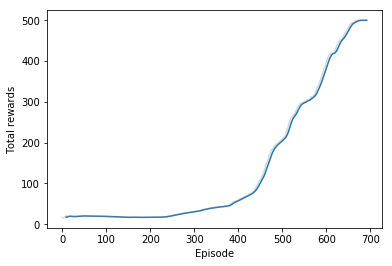

In [20]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

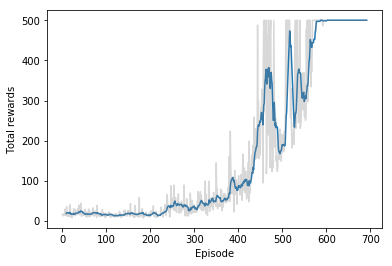

In [21]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

## Testing

Let's checkout how our trained agent plays the game.

In [23]:
# Creating a gym env
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

# A training graph session
with tf.Session(graph=graph) as sess:
    #sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model-qn.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(10):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
                
        # Closing the env
        print('total_reward: {}'.format(total_reward))
# Close the env at the end
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model-qn.ckpt


/home/arasdar/anaconda3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.